In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
from scipy import signal
from scipy.interpolate import LinearNDInterpolator
from typing import Union, List, Tuple, Dict
import os

from cell_inference.config import paths, params
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.transform.distribution_transformation import range2norm, range2logn
from cell_inference.utils.transform.geometry_transformation import pol2cart, cart2pol
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder


h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD, index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

### Load files

In [2]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Geo_3_params')

TRIAL_CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels
MEM_VOLT_PATH = os.path.join(TRIAL_PATH, 'mem_volt.npz')  # membrane voltage and spike times

In [3]:
f_config = open(TRIAL_CONFIG_PATH, 'r')
config_dict = json.load(f_config)
f_config.close()

loc_param_list = config_dict['Simulation_Parameters']['loc_param_list']
geo_param_list = config_dict['Simulation_Parameters']['geo_param_list']
loc_param_default = config_dict['Simulation_Parameters']['loc_param_default']
geo_param_default = config_dict['Simulation_Parameters']['geo_param_default']
loc_param_range = config_dict['Simulation_Parameters']['loc_param_range']
geo_param_range = config_dict['Simulation_Parameters']['geo_param_range']

Check configurations

In [4]:
for key, value in config_dict['Simulation_Parameters'].items():
    print(key+": ", json.dumps(value))

loc_param_list:  ["x", "y", "z", "alpha", "h", "phi"]
geo_param_list:  ["r_s", "l_t", "r_t", "r_d", "r_tu", "l_d"]
loc_param_default:  {"x": 0.0, "y": 0.0, "z": 50.0, "alpha": 0.7853981633974483, "h": 1.0, "phi": 0.0, "d": 50.0, "theta": 0.0}
geo_param_default:  {"r_s": 8.0, "l_t": 600.0, "r_t": 1.25, "r_d": 0.28, "r_tu": 0.28, "l_d": 200.0}
loc_param_range:  {"x": [-50, 50], "y": [-1400, 1400], "z": [20.0, 200.0], "alpha": [0, 3.141592653589793], "h": [-1.0, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [20.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976]}
geo_param_range:  {"r_s": [7.0, 12.0], "l_t": [20.0, 800.0], "r_t": [0.6, 1.8], "r_d": [0.1, 0.8], "r_tu": [0.1, 0.8], "l_d": [100.0, 300.0]}
loc_param_dist:  {"x": "unif", "y": "unif", "z": "unif", "alpha": "unif", "h": "unif", "phi": "unif", "d": "unif", "theta": "norm"}
geo_param_dist:  {"r_s": "unif", "l_t": "unif", "r_t": "unif", "r_d": "logn", "r_tu": "logn", "l_d": "unif"}


### Set parameters to investigate

In [5]:
SINGLE_PARAM = False  # Study single parameter. Otherwise, use generated samples in simulated data. 

if SINGLE_PARAM:
    number_samples = 100  # number of samples
    check_param = 'r_s'  # single parameter to vary
    check_range = None  # or a tuple of range. Samples will be linearly spaced within the range
    set_default = {}  # specify fixed parameters if any different from loaded configuration, e.g. {'r_s': 10.}
else: 
    sample_idx = np.arange(0, 100, 1)  # sample indices to investigate
    sample_idx = np.array(sample_idx).ravel()
    number_samples = sample_idx.size
    print(number_samples)
    check_param = None
    check_range = None
    set_default = {}
    with np.load(LFP_PATH) as lfp_data:
        labels = lfp_data['y']
        rand_param = lfp_data['rand_param']
        gmax = lfp_data['gmax']

100


#### Generate samples

In [6]:
if SINGLE_PARAM:
    gmax_mapping = h5py.File(paths.GMAX_MAPPING, 'r')

    geo_list = [geo_param_list[idx] for idx in gmax_mapping['settings/geo_index']]
    for i, key in enumerate(geo_list):
        geo_range = gmax_mapping['settings/geo_range'][i,:].copy()
        geo_range[0] = max(geo_param_range[key][0], geo_range[0])
        geo_range[1] = min(geo_param_range[key][1], geo_range[1])
        geo_param_range[key] = tuple(geo_range) 

    squared_soma_radius = gmax_mapping['mapping'].attrs['squared_soma_radius']

    # Use linear interpolation
    gmax_interp = LinearNDInterpolator(gmax_mapping['mapping/geometry'][()], gmax_mapping['mapping/gmax'][()])

    gmax_mapping.close()

    # # Use linear regression
    # clf = ClassifierBuilder()
    # clf.load_clf(paths.RESOURCES_ROOT + "gmax_lin_reg_classifier.joblib")

    def pred_gmax(geo_samples: Dict):
        geo = []
        for key in geo_list:
            if squared_soma_radius and key == 'r_s':
                geo.append(geo_samples[key]**2)
            else:
                geo.append(geo_samples[key])
        gmax = gmax_interp(np.column_stack(geo))
    #     gmax = clf.predict(np.column_stack(geo))
        return gmax

In [7]:
set_default_list = set_default.keys()
for param_default in [loc_param_default,geo_param_default]:
    for key in param_default.keys():
        if key in set_default_list:
            param_default[key] = set_default[key]

if 'x' in set_default_list or 'z' in set_default_list:
    loc_param_default['d'], loc_param_default['theta'] = cart2pol(loc_param_default['x'], loc_param_default['z'])

if 'd' in set_default_list or 'theta' in set_default_list:
    loc_param_default['x'], loc_param_default['z'] = pol2cart(loc_param_default['d'], loc_param_default['theta'])

In [8]:
def generate_parameters(num: int, param_keys: List[str], param_default: List[float], 
                        param_range: List[Union[List[float],Tuple[float],np.ndarray]]):
    global check_range
    array_size = num
    param_array = {}
    for key in param_keys:
        if key == check_param:
            if check_range is None:
                check_range = param_range[key]
            param_array[key] = np.linspace(check_range[0], check_range[1], num=np.prod(array_size)).reshape(array_size)
        else:
            param_array[key] = np.full(array_size, param_default[key])
    return param_array

In [9]:
loc_param_gen = loc_param_list.copy()
if check_param in ['d', 'theta']:
    loc_param_gen[loc_param_gen.index('x')] = 'd'
    loc_param_gen[loc_param_gen.index('z')] = 'theta'

loc_param_samples = generate_parameters(number_samples, loc_param_gen, loc_param_default, loc_param_range)

if check_param in ['d', 'theta']:
    loc_param_samples['x'], loc_param_samples['z'] = pol2cart(loc_param_samples['d'],loc_param_samples['theta'])

loc_param = np.column_stack([loc_param_samples[key] for key in loc_param_list])

In [10]:
geo_param_samples = generate_parameters(number_samples, geo_param_list, geo_param_default, geo_param_range)

geo_param = np.column_stack([geo_param_samples[key] for key in geo_param_list])

In [11]:
if SINGLE_PARAM:
    gmax = pred_gmax(geo_param_samples)
else:
    inference_list = config_dict['Trial_Parameters']['inference_list']
    randomized_list = config_dict['Trial_Parameters']['randomized_list'][:-len(inference_list)]
    all_param = np.hstack((loc_param,geo_param))
    labels_idx = []
    rand_param_idx = []
    for i, key in enumerate(loc_param_list+geo_param_list):
        if key in inference_list:
            labels_idx.append(i)
        elif key in randomized_list:
            rand_param_idx.append(i)
    all_param[:,np.asarray(labels_idx)] = labels[sample_idx]
    all_param[:,np.asarray(rand_param_idx)] = rand_param[sample_idx]
    loc_param = all_param[:,:len(loc_param_list)]
    geo_param = all_param[:,len(loc_param_list):]
    gmax = gmax[sample_idx]

#### Check parameters of all samples

In [12]:
all_param = pd.DataFrame(np.column_stack((loc_param,geo_param,gmax)), columns=loc_param_list+geo_param_list+['gmax'])
pd.set_option('display.max_columns', None)

display(all_param)

,x,y,z,alpha,h,phi,r_s,l_t,r_t,r_d,r_tu,l_d,gmax
0,0.0,0.0,50.0,0.714197,1.0,0.0,7.945023,614.503631,1.792226,0.28,0.28,200.0,0.026298
1,0.0,0.0,50.0,0.995126,1.0,0.0,11.910271,190.858449,1.783744,0.28,0.28,200.0,0.037556
2,0.0,0.0,50.0,2.504997,1.0,0.0,7.092766,770.561195,1.370404,0.28,0.28,200.0,0.017285
3,0.0,0.0,50.0,2.124517,1.0,0.0,7.882055,644.768225,1.203752,0.28,0.28,200.0,0.018929
4,0.0,0.0,50.0,1.228707,1.0,0.0,8.495207,140.592047,1.171624,0.28,0.28,200.0,0.026298
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,50.0,1.189877,1.0,0.0,7.715499,480.141520,0.711235,0.28,0.28,200.0,0.018160
96,0.0,0.0,50.0,0.866913,1.0,0.0,9.237047,274.670456,1.289813,0.28,0.28,200.0,0.030722
97,0.0,0.0,50.0,3.035106,1.0,0.0,9.328595,768.247195,1.771545,0.28,0.28,200.0,0.027450
98,0.0,0.0,50.0,0.182849,1.0,0.0,8.386625,601.258363,1.015400,0.28,0.28,200.0,0.021361


### Create simulation and run

In [13]:
sim = Simulation(geometry = geo_standard, 
                 electrodes = params.ELECTRODE_POSITION, 
                 cell_type = CellTypes.ACTIVE, 
                 loc_param = loc_param, 
                 geo_param = geo_param,
                 spike_threshold = -30, 
                 gmax = gmax, 
                 scale = 1., 
                 ncell = number_samples)

sim.run_neuron_sim()

Check invalid spiking cases

In [14]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes

%matplotlib inline

def plot_v(sim: Simulation, cell_idx: np.ndarray = None,
           figsize: Union[List[float],Tuple[float]] = (6,2)) -> Tuple[Figure, Axes]:
    if cell_idx is None:
        cell_idx = np.arange(sim.ncell)
    elif cell_idx.size == 0:
        return
    t = sim.t()
    fig, axs = plt.subplots(nrows=cell_idx.size, ncols=1)
    fig.set_size_inches(figsize[0],figsize[1]*cell_idx.size)
    axs = np.asarray(axs).ravel()
    for i, ax in enumerate(axs):
        ax.plot(t, sim.v(cell_idx[i]), label="cell %d" % (cell_idx[i]))
        ax.set_ylabel('Vm (mV)')
        ax.legend(loc=1)
    axs[0].set_title('Membrane Voltage vs Time')
    axs[-1].set_xlabel('Time (ms)')
    plt.show()
    return fig, axs

def invalid_index(sim):
    # index of valid spiking cells
    nspk, tspk = sim.get_spike_number('all')
    invalid = np.nonzero(nspk != 1)[0]
    return invalid, tspk

Number of invalid samples: 0 out of 100


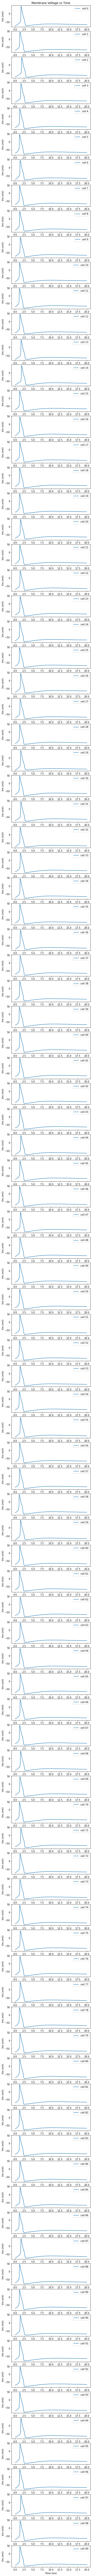

In [15]:
invalid_idx, _ = invalid_index(sim)
print("Number of invalid samples: %d out of %d" % (invalid_idx.size, number_samples))

_ = plot_v(sim)

### Get LFPs

In [16]:
lfp = sim.get_lfp('all').transpose((0,2,1))  # (cells x channels x time) -> (cells x time x channels)

filt_b, filt_a = signal.butter(params.BUTTERWORTH_ORDER,
                              params.FILTER_CRITICAL_FREQUENCY,
                              params.BANDFILTER_TYPE,
                              fs=params.FILTER_SAMPLING_RATE)

filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=1)  # filter along time axis

pk_tr_idx_in_window = 16  # 16*0.025=0.4 ms
lfp_list = []
window_range = []
for i in range(number_samples):
#     filtered_lfp[i] /= np.max(np.abs(filtered_lfp[i]))
    fst_idx = first_pk_tr(filtered_lfp[i])
    start, end = get_spike_window(filtered_lfp[i], win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
    lfp_list.append(filtered_lfp[i,start:end,:])
    window_range.append((start, end))

windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)

In [17]:
from ipywidgets import Output, HBox, VBox, Label, Layout

ix = 1  # ix-th column of electrode along x-axis
# vlim = 'auto'  # heatmap color limit
vlim = 0.002*np.array([-1.,1.])

fig_properties = {'fontsize': 15, 'labelpad': 0, 'ticksize': 10, 'nbins': 5}

t = sim.t()
x_dist = np.unique(params.ELECTRODE_POSITION[:,0])
elec_pos = params.ELECTRODE_POSITION
e_idx = elec_pos[:,0]==x_dist[ix]

print('Using column at x = %g um' % (x_dist[ix]))

outputs = []
for i in range(number_samples):
    out = [Output() for i in range(3)]
    with out[0]:
        _ = plot_lfp_heatmap(t, elec_pos[e_idx, 1], lfp[i][:,e_idx], 
                             vlim=vlim, **fig_properties)
    with out[1]:
            _ = plot_lfp_heatmap(t, elec_pos[e_idx, 1], filtered_lfp[i][:,e_idx],
                             vlim=vlim, **fig_properties)
    with out[2]:
        tidx = slice(window_range[i][0],window_range[i][1])
        _ = plot_lfp_heatmap(t[tidx], elec_pos[e_idx, 1], windowed_lfp[i][:,e_idx],
                             vlim=vlim, **fig_properties)
    outputs.append(out)

around = Layout(justify_content='space-around')
out = VBox( [HBox( [Label('Raw LFP'), Label('Filtered LFP'), Label('Windowed LFP')], layout=around )]
          + [HBox(out, layout=around) for i,out in enumerate(outputs)] )
display(out)

Using column at x = -8 um


### Get summary statistics

In [18]:
summ_stats = []
for i in range(number_samples):
    g_lfp, _ = build_lfp_grid(windowed_lfp[i], params.ELECTRODE_POSITION)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

In [19]:
stats_along_time = ['avg', 'rel_t', 'std', 'trough', 'peak']
stats_along_xy = ['mean', 'std', 'max_idx_x', 'max_idx_y', 'max_val', 'min_idx_x', 'min_idx_y', 'min_val']
i_min = 2  # include minimum statistics for the first i_min in stats_list
extra_stats = ['t0', 't1', 't2',
               't0_idx_y_left', 't0_idx_y_right',
               't2_idx_y_left', 't2_idx_y_right',
               't1_max_idx_y', 't1_min_idx_y']

summ_stats_names = []
for i, st in enumerate(stats_along_time):
    stats_xy = stats_along_xy if i<i_min else stats_along_xy[:-3]
    for sxy in stats_xy:
        summ_stats_names.append('__'.join([st,sxy]))
summ_stats_names += extra_stats
print("%d summary stats" % (len(summ_stats_names)))
print(json.dumps(summ_stats_names))

40 summary stats
["avg__mean", "avg__std", "avg__max_idx_x", "avg__max_idx_y", "avg__max_val", "avg__min_idx_x", "avg__min_idx_y", "avg__min_val", "rel_t__mean", "rel_t__std", "rel_t__max_idx_x", "rel_t__max_idx_y", "rel_t__max_val", "rel_t__min_idx_x", "rel_t__min_idx_y", "rel_t__min_val", "std__mean", "std__std", "std__max_idx_x", "std__max_idx_y", "std__max_val", "trough__mean", "trough__std", "trough__max_idx_x", "trough__max_idx_y", "trough__max_val", "peak__mean", "peak__std", "peak__max_idx_x", "peak__max_idx_y", "peak__max_val", "t0", "t1", "t2", "t0_idx_y_left", "t0_idx_y_right", "t2_idx_y_left", "t2_idx_y_right", "t1_max_idx_y", "t1_min_idx_y"]


In [20]:
summ_stats_df = pd.DataFrame(summ_stats, columns=summ_stats_names)
pd.set_option('display.max_columns', None)

display(summ_stats_df)

,avg__mean,avg__std,avg__max_idx_x,avg__max_idx_y,avg__max_val,avg__min_idx_x,avg__min_idx_y,avg__min_val,rel_t__mean,rel_t__std,rel_t__max_idx_x,rel_t__max_idx_y,rel_t__max_val,rel_t__min_idx_x,rel_t__min_idx_y,rel_t__min_val,std__mean,std__std,std__max_idx_x,std__max_idx_y,std__max_val,trough__mean,trough__std,trough__max_idx_x,trough__max_idx_y,trough__max_val,peak__mean,peak__std,peak__max_idx_x,peak__max_idx_y,peak__max_val,t0,t1,t2,t0_idx_y_left,t0_idx_y_right,t2_idx_y_left,t2_idx_y_right,t1_max_idx_y,t1_min_idx_y
0,0.000012,0.000234,1.0,95.0,0.001174,2.0,122.0,-0.000449,0.932895,57.729423,0.0,0.0,64.0,1.0,132.0,-79.0,0.000992,0.001645,2.0,94.0,0.008351,0.002556,0.004341,2.0,94.0,0.025134,0.001660,0.003185,2.0,94.0,0.015881,16.0,31.0,62.0,91.0,96.0,91.0,97.0,112.0,100.0
1,0.000013,0.000066,1.0,95.0,0.000439,3.0,107.0,-0.000101,1.909211,43.722341,0.0,0.0,45.0,0.0,110.0,-45.0,0.000575,0.001222,2.0,94.0,0.007168,0.001562,0.003560,2.0,94.0,0.025038,0.001422,0.003146,2.0,100.0,0.016507,16.0,16.0,16.0,90.0,96.0,90.0,96.0,100.0,94.0
2,0.000005,0.000201,1.0,95.0,0.000970,1.0,127.0,-0.000390,-10.113158,67.673658,0.0,114.0,59.0,0.0,143.0,-123.0,0.000724,0.001145,2.0,94.0,0.005408,0.001849,0.002887,2.0,94.0,0.015372,0.001017,0.001961,2.0,94.0,0.010610,16.0,33.0,63.0,91.0,96.0,91.0,97.0,111.0,100.0
3,0.000007,0.000160,1.0,95.0,0.000800,1.0,125.0,-0.000318,-12.177632,65.109453,0.0,0.0,48.0,0.0,135.0,-122.0,0.000556,0.000950,2.0,94.0,0.004798,0.001394,0.002351,2.0,94.0,0.013301,0.000804,0.001632,2.0,94.0,0.009573,16.0,33.0,63.0,91.0,96.0,91.0,97.0,110.0,100.0
4,0.000012,0.000059,1.0,95.0,0.000412,3.0,105.0,-0.000072,2.086842,44.520549,1.0,97.0,49.0,0.0,111.0,-46.0,0.000270,0.000629,1.0,95.0,0.003824,0.000703,0.001670,1.0,95.0,0.010987,0.000606,0.001412,1.0,95.0,0.007442,16.0,31.0,62.0,91.0,97.0,91.0,97.0,93.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000005,0.000084,1.0,95.0,0.000456,2.0,120.0,-0.000250,-23.494737,92.180444,0.0,108.0,91.0,0.0,138.0,-153.0,0.000224,0.000454,1.0,95.0,0.002757,0.000513,0.001019,1.0,95.0,0.006559,0.000302,0.000712,1.0,95.0,0.005328,16.0,36.0,62.0,92.0,97.0,92.0,97.0,109.0,100.0
96,0.000012,0.000089,1.0,95.0,0.000535,3.0,111.0,-0.000197,2.218421,44.723386,0.0,69.0,46.0,3.0,113.0,-52.0,0.000452,0.000925,2.0,94.0,0.005409,0.001096,0.002314,2.0,94.0,0.014970,0.000915,0.001949,2.0,94.0,0.010951,16.0,32.0,62.0,91.0,96.0,91.0,97.0,109.0,99.0
97,0.000009,0.000264,1.0,95.0,0.001233,1.0,127.0,-0.000487,-7.080263,60.191275,0.0,0.0,49.0,0.0,141.0,-101.0,0.001101,0.001711,1.0,95.0,0.007682,0.002869,0.004469,2.0,94.0,0.022689,0.001715,0.003213,1.0,95.0,0.015298,16.0,32.0,63.0,90.0,96.0,90.0,97.0,112.0,100.0
98,0.000005,0.000128,1.0,95.0,0.000622,1.0,127.0,-0.000292,-9.994737,70.213715,0.0,114.0,81.0,0.0,133.0,-131.0,0.000421,0.000747,2.0,94.0,0.003695,0.001030,0.001790,2.0,94.0,0.009153,0.000590,0.001233,2.0,94.0,0.007348,16.0,35.0,63.0,91.0,97.0,91.0,97.0,110.0,100.0


In [57]:
varied_parameter_column = all_param['r_s']
correlations1 = {column: [varied_parameter_column.corr(summ_stats_df[column])] for column in summ_stats_df}
# correlations1 = dict(sorted(correlations1.items(), key=lambda item: item[1]))
# print(json.dumps(correlations1, indent=2))

In [58]:
varied_parameter_column = all_param['l_t']
correlations2 = {column: [varied_parameter_column.corr(summ_stats_df[column])] for column in summ_stats_df}
# correlations2 = dict(sorted(correlations2.items(), key=lambda item: item[1]))
# print(json.dumps(correlations2, indent=2))

In [59]:
varied_parameter_column = all_param['r_t']
correlations3 = {column: [varied_parameter_column.corr(summ_stats_df[column])] for column in summ_stats_df}
# correlations3 = dict(sorted(correlations3.items(), key=lambda item: item[1]))
# print(json.dumps(correlations3, indent=2))

In [66]:
combined = {}

for k, v in correlations1.items():
    combined[k] = [v[0], correlations2[k][0], correlations3[k][0]]
    
combined_stats = pd.DataFrame.from_dict(combined)
pd.set_option('display.max_columns', None)

display(combined_stats)

,avg__mean,avg__std,avg__max_idx_x,avg__max_idx_y,avg__max_val,avg__min_idx_x,avg__min_idx_y,avg__min_val,rel_t__mean,rel_t__std,rel_t__max_idx_x,rel_t__max_idx_y,rel_t__max_val,rel_t__min_idx_x,rel_t__min_idx_y,rel_t__min_val,std__mean,std__std,std__max_idx_x,std__max_idx_y,std__max_val,trough__mean,trough__std,trough__max_idx_x,trough__max_idx_y,trough__max_val,peak__mean,peak__std,peak__max_idx_x,peak__max_idx_y,peak__max_val,t0,t1,t2,t0_idx_y_left,t0_idx_y_right,t2_idx_y_left,t2_idx_y_right,t1_max_idx_y,t1_min_idx_y
0,0.093524,-0.109210,-0.171013,0.171013,-0.124083,0.070486,-0.092438,0.116815,-0.029146,-0.052780,-0.099017,-0.089983,-0.040569,0.084037,-0.035736,0.055252,-0.028563,0.002471,-0.033583,0.033583,0.035838,-0.020754,0.016955,-0.108337,0.000097,0.057936,0.033140,0.062573,-0.042132,0.228502,0.097625,NaN,-0.125431,-0.203884,-0.123875,0.032796,0.038461,-0.131441,-0.020873,-0.187390
1,-0.673144,0.838358,-0.235422,0.235422,0.773385,0.055978,0.962722,-0.904407,-0.629660,0.687619,-0.365692,-0.286905,0.393064,0.081028,0.844619,-0.798304,0.652639,0.533248,-0.077912,0.077912,0.377872,0.636736,0.478704,-0.001294,-0.023055,0.286255,0.412755,0.327324,-0.058336,-0.322159,0.340714,NaN,0.266895,0.338874,-0.054812,-0.019780,-0.093155,0.182154,0.753649,0.517852
2,0.446467,0.511514,0.304999,-0.304999,0.575232,-0.137778,0.152485,-0.346457,0.435815,-0.437516,-0.175068,-0.576449,-0.478131,0.088547,-0.116544,0.387347,0.751620,0.815052,0.290261,-0.290261,0.855191,0.773989,0.854744,0.458076,-0.574260,0.886747,0.868018,0.889606,0.344495,0.142340,0.875000,NaN,-0.428444,-0.218158,-0.815120,-0.798003,-0.545070,-0.323142,0.128352,-0.238735
